필요 라이브러리 import

In [104]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np


데이터 불러오기/체크

                  path  width  height   w/h   bha   class
0  images/addict/1.jpg    261     193  1.35  0.30  addict
1  images/addict/2.jpg    300     168  1.79  0.44  addict
2  images/addict/3.jpg    268     188  1.43  0.47  addict
3  images/addict/4.jpg    194     259  0.75  0.42  addict
4  images/addict/5.jpg    300     168  1.79  0.37  addict


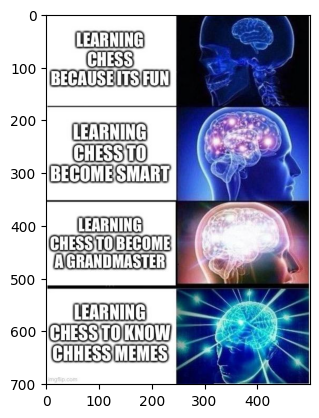

In [107]:
import random
train = pd.read_csv("data/raw_train.csv")
print(train.head())
sample_img = Image.open(train.iloc[random.randint(0,9000)]["path"])
plt.imshow(sample_img)

                  path  width  height   class
0  images/addict/1.jpg    261     193  addict
1  images/addict/2.jpg    300     168  addict
2  images/addict/3.jpg    268     188  addict
3  images/addict/4.jpg    194     259  addict
4  images/addict/5.jpg    300     168  addict


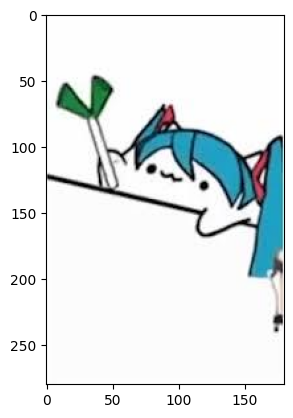

In [108]:
import random
train = pd.read_csv("data/modi_train.csv")
print(train.head())
sample_img = Image.open(train.iloc[random.randint(0,9000)]["path"])
plt.imshow(sample_img)

In [109]:
train["class"].value_counts()

class
wojak                   300
laughing wolf           300
grim reaper             300
left exit               300
fuck yea                300
pepe                    300
shut up                 300
starwars                300
expanding brain         300
draw 25                 300
drakeposting            300
trollface               300
tuxedo pooh             300
cheers                  300
vsdoge                  300
boardroom meeting       300
bad luck                300
always has been         300
grus plan               300
distracted boyfriend    298
dooly                   280
bereal                  256
Bongo Cat               248
mococo                  241
two buttons             240
baton roue              240
thour                   225
addict                  223
SMEscat                 206
luffy                   177
study                   175
noanswer                175
click                   173
dat boi                 173
nyan cat                167
dont say      

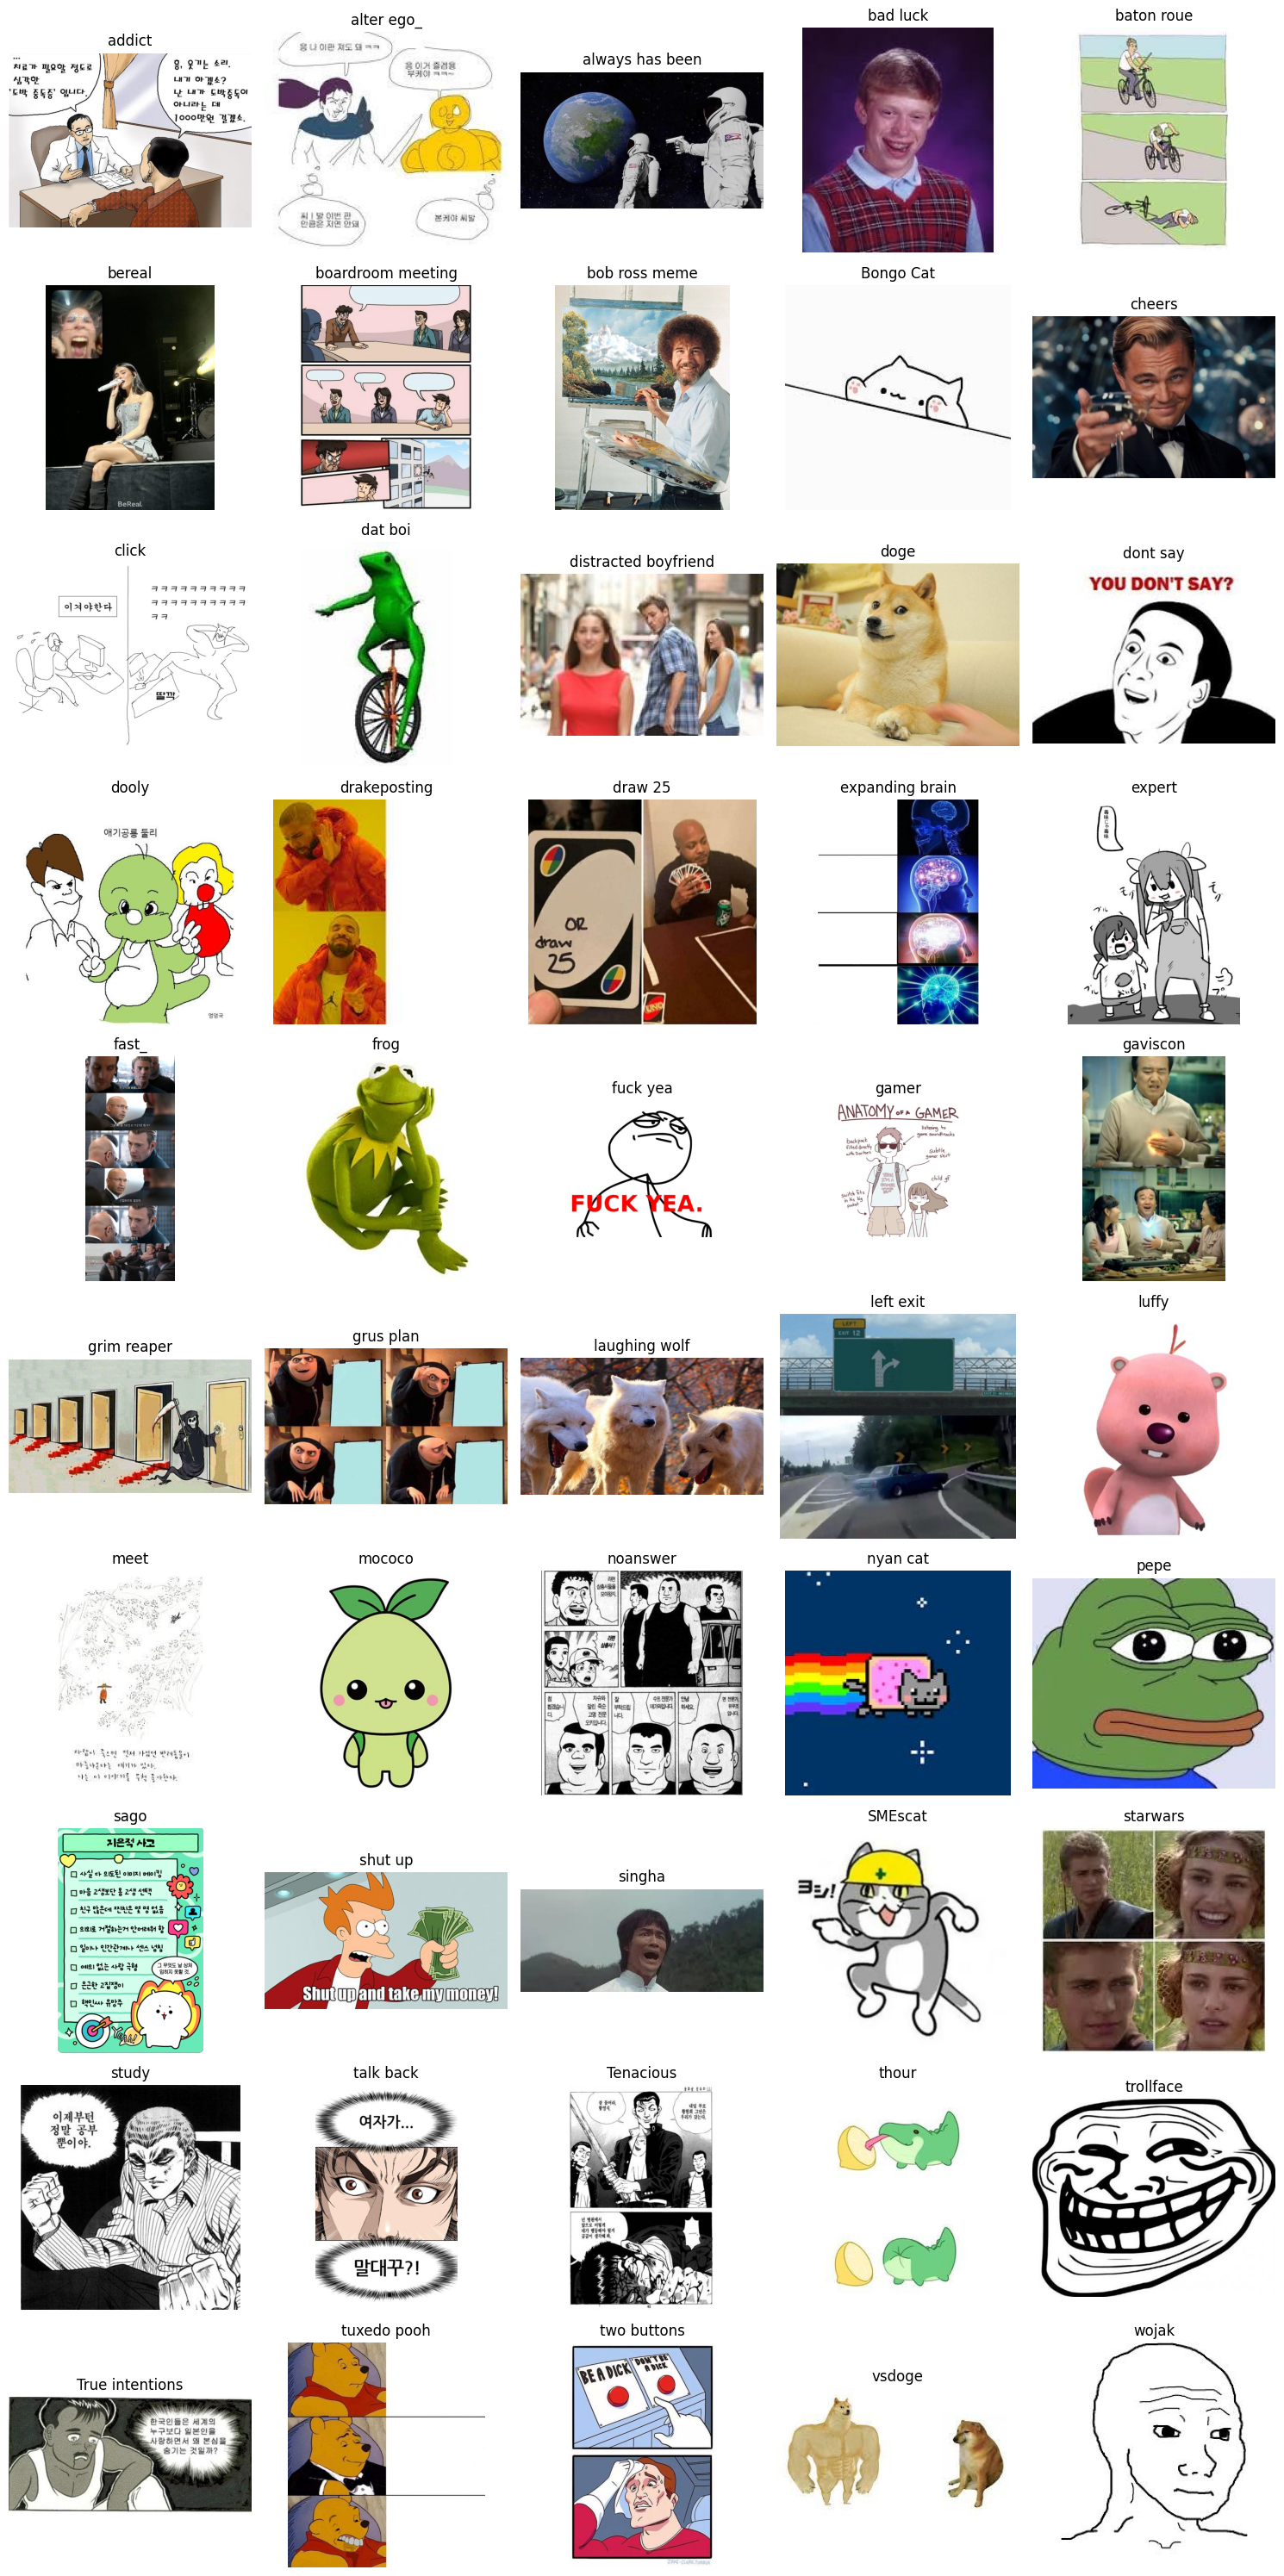

In [112]:
class_image = os.listdir("images")
num_samples_per_row = 5
num_rows = (len(class_image) // num_samples_per_row) + (1 if len(class_image) % num_samples_per_row != 0 else 0)

plt.figure(figsize=(15, num_rows * 3))  # figsize의 높이를 행 수에 따라 조정

for i, img_name in enumerate(class_image):
    sample_img = Image.open(f"images/{img_name}/0.jpg")
    plt.subplot(num_rows, num_samples_per_row, i + 1)
    plt.imshow(sample_img)
    plt.title(img_name)
    plt.axis('off')
    if i == len(class_image): break  # 최대 30개의 이미지만 표시

plt.tight_layout()
plt.show()

이미지 파일 사이즈 분포 시각화

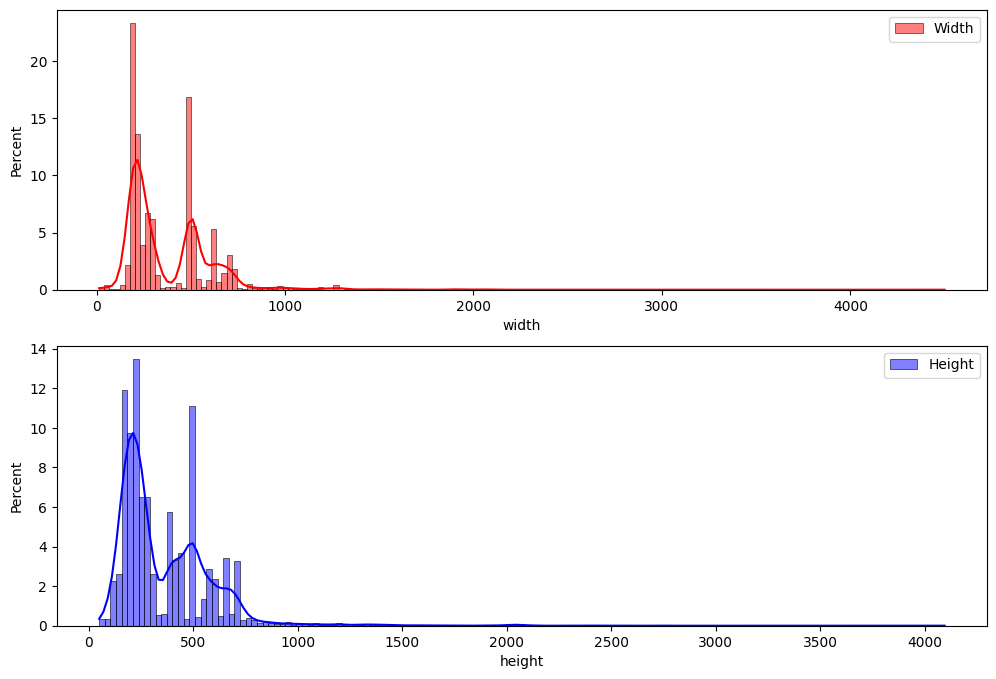

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.set_palette('tab10')
sns.histplot(train, x='width', kde=True, stat='percent', label='Width', ax=ax[0], color='r')
ax[0].legend()
sns.histplot(train, x='height', kde=True, stat='percent', label='Height', ax=ax[1], color='b')
ax[1].legend()

In [70]:
print(
    f"[너비] 평균: {train['width'].mean()}\n"
    f"[너비] 중간값(median): {train['width'].median()}\n"
    f"[너비] 표준편차: {train['width'].std(ddof=0)}"
)
print("=" * 50)
print(
    f"[높이] 평균: {train['height'].mean()}\n"
    f"[높이] 중간값(median): {train['height'].median()}\n"
    f"[높이] 표준편차: {train['height'].std(ddof=0)}"
)

[너비] 평균: 384.8946351338916
[너비] 중간값(median): 276.0
[너비] 표준편차: 249.64141769846324
[높이] 평균: 365.7327689334683
[높이] 중간값(median): 273.0
[높이] 표준편차: 241.25093800433436


In [71]:
img_width, img_height = train['width'].mean(), train['height'].mean()
while 1:
    if img_height > 256 or img_width > 256:
        img_width = int(img_width // 2)
        img_height = int(img_height // 2)
    else:
        break

print(img_width, img_height)

# img_height, img_width = 224, 224

192 182


In [72]:
import cv2
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blurry_images = []
for path in train["path"]:
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if variance_of_laplacian(img) < 100:
           blurry_images.append(path)
    except: 
        print(f"{path}에서 오류 발생")
        continue
print(f'블러처리 의심 항목 개수: {len(blurry_images)}')

블러처리 의심 항목 개수: 45


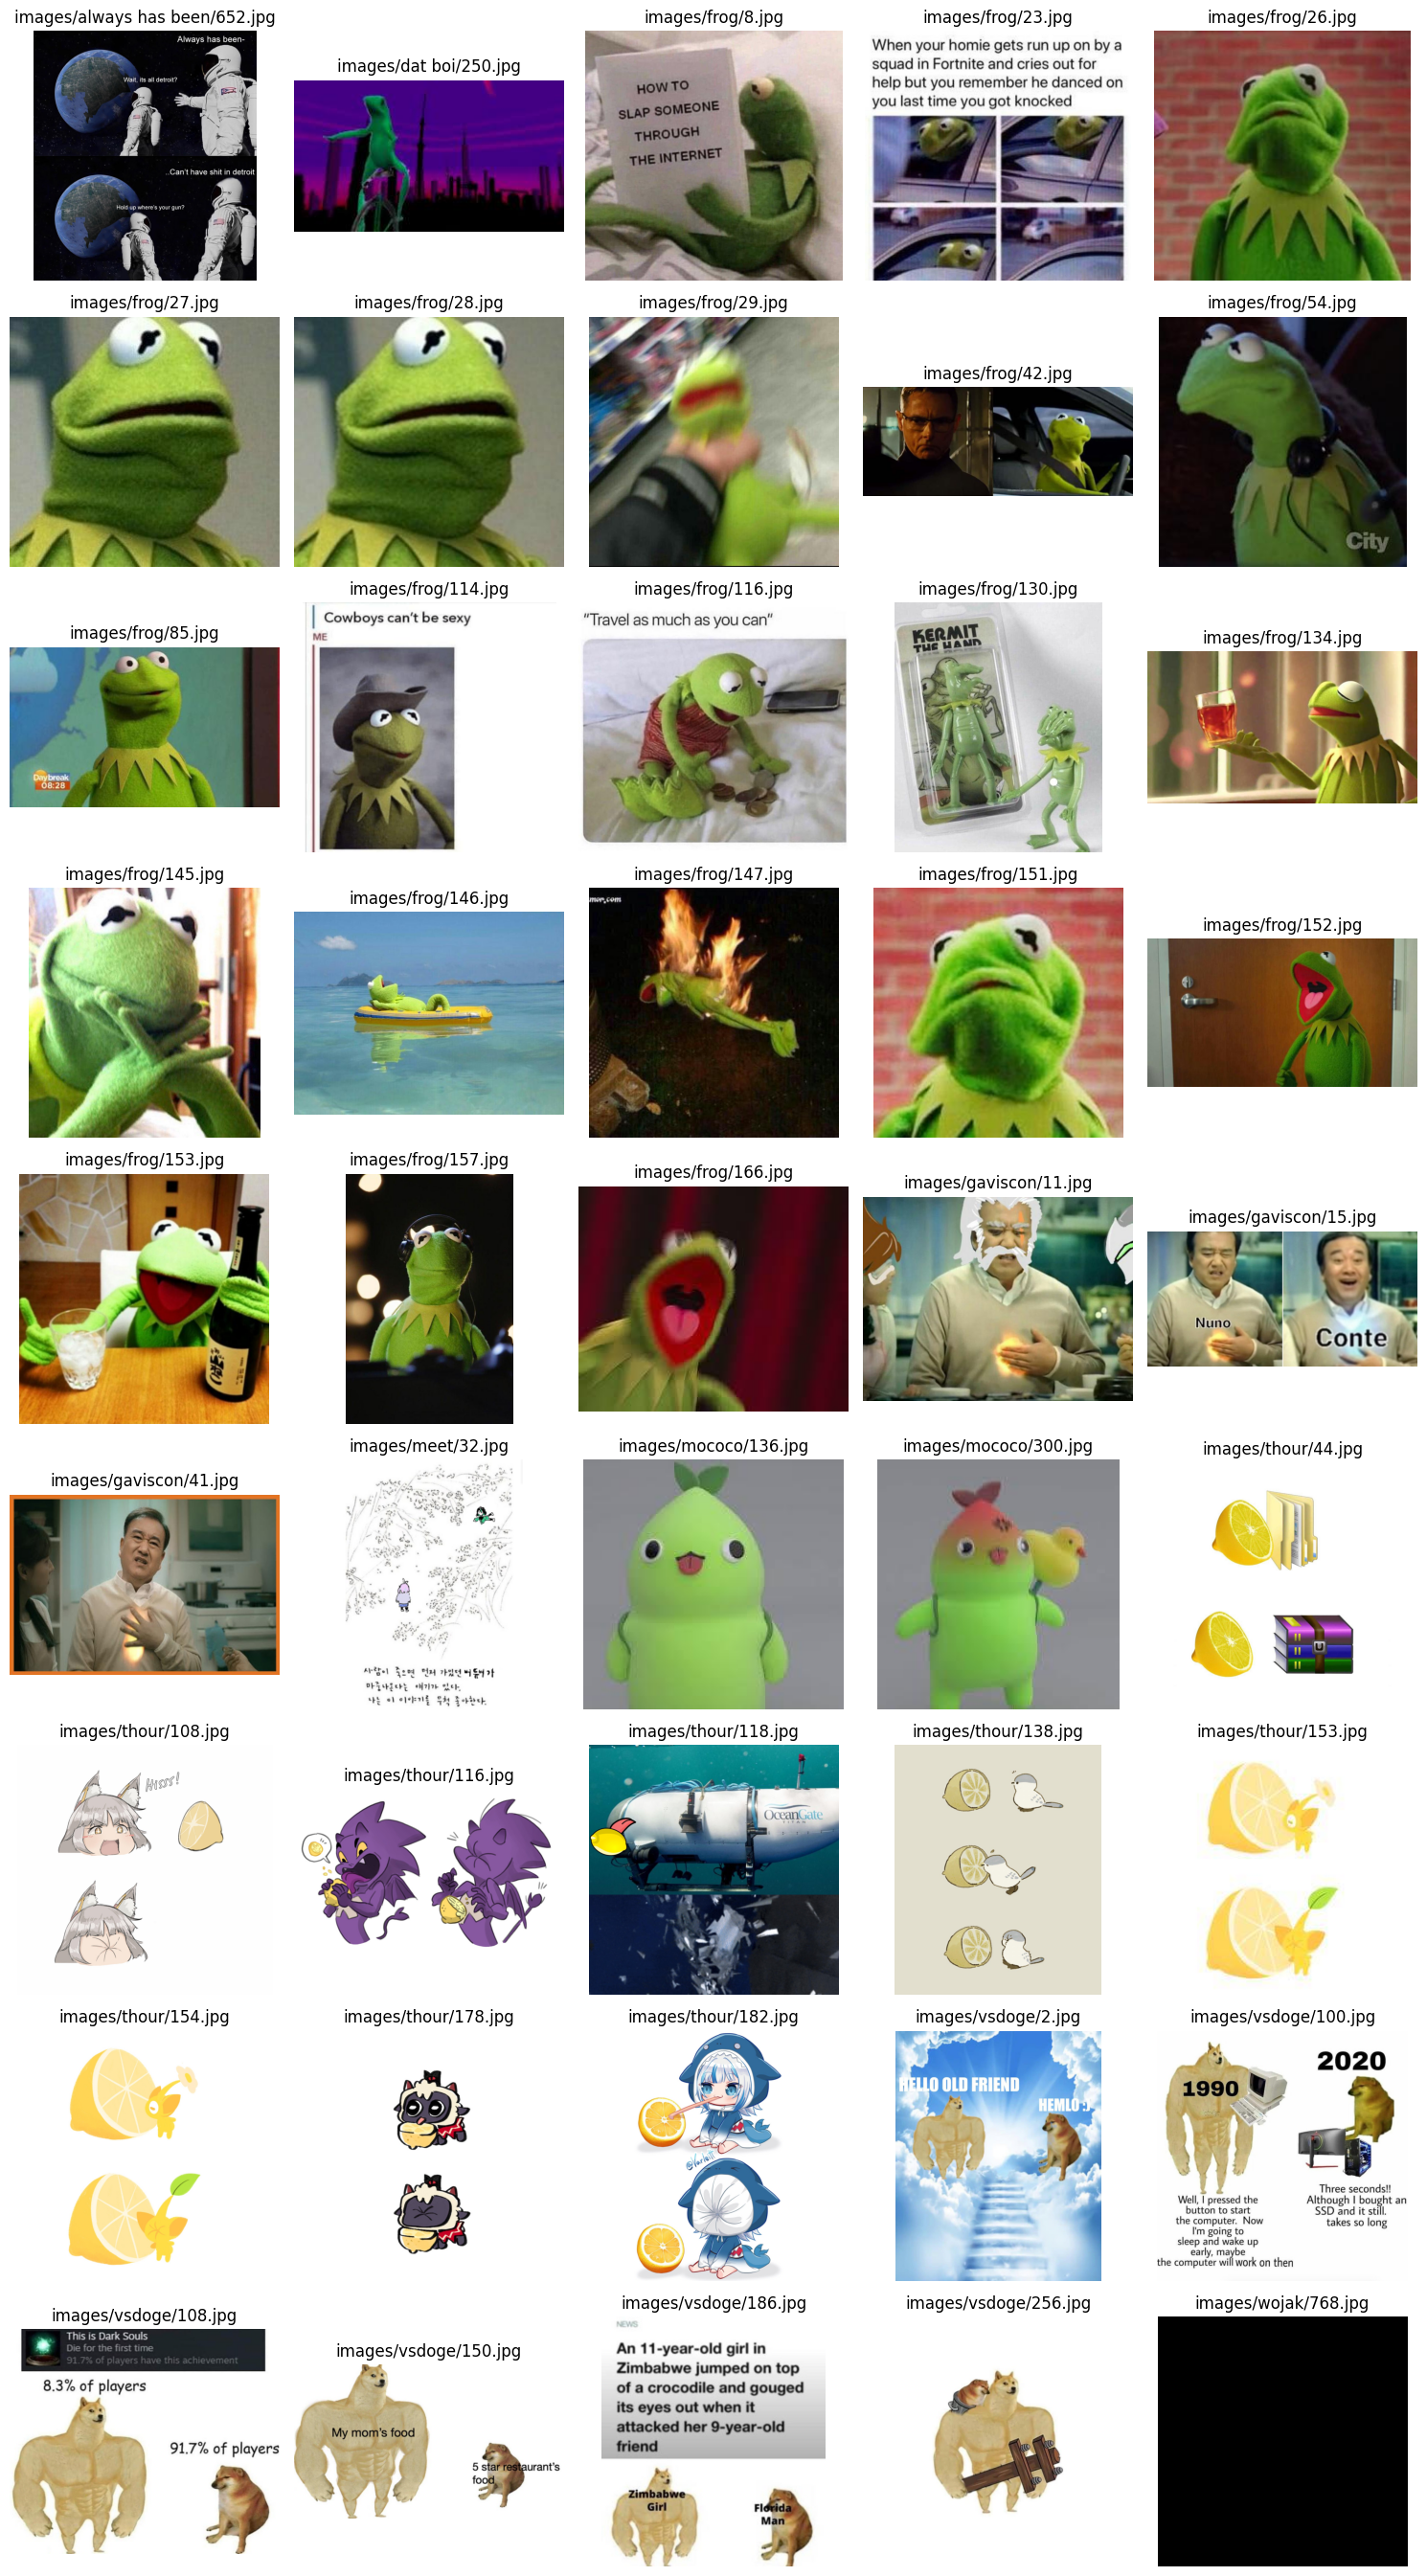

In [73]:
class_image = blurry_images
num_samples_per_row = 5
num_rows = (len(class_image) // num_samples_per_row) + (1 if len(class_image) % num_samples_per_row != 0 else 0)

plt.figure(figsize=(15, num_rows * 3))  # figsize의 높이를 행 수에 따라 조정

for i, img_name in enumerate(class_image):
    sample_img = Image.open(f"{img_name}")
    plt.subplot(num_rows, num_samples_per_row, i + 1)
    plt.imshow(sample_img)
    plt.title(img_name)
    plt.axis('off')
    if i == len(class_image): break  # 최대 30개의 이미지만 표시

plt.tight_layout()
plt.show()

CNN에 넣을 이미지 데이터는 모두 같은 사이즈를 가져야 함, 너무 크면 안됨 -> 너비, 높이 평균값을 가져온 후 둘 모두 256 이하가 될때까지 2를 나눈 값을 사용하고자 함

dataset에서 필요한 정보인 path와 class만 가져옴, 다중 분류이기 때문에 클래스에 레이블 인코딩 적용

In [74]:
import pickle
path = train['path']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['class'])

labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))
print(train['class'])
print(len(labels[0]))
with open('models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)
classes = len(labels[0])

0        addict
1        addict
2        addict
3        addict
4        addict
          ...  
10862     wojak
10863     wojak
10864     wojak
10865     wojak
10866     wojak
Name: class, Length: 10867, dtype: object
49


차후 사용할 datasetV2 자료형은 train_test_split을 지원하지 않음 -> 미리 나눈 후 datasetV2로 변환

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(path, labels, test_size=0.2, random_state=123)

더 효율적인 학습을 위해 path, class를 datasetV2 자료형으로 변형

In [77]:
def image_preprocessing(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3) #이미지 디코딩, 컬러(RGB)이미지기에 channels는 3으로 지정
    image = tf.image.resize(image, [img_height, img_width])  # 이미지 크기 조정
    image = image / 255.0  # RGB값은 0~255의 값을 가짐 -> 255로 나누어 0~1의 값으로 정규화

    return image, label

def create_dataset(paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels)) #path, labels를 datasetV2로 만듦
    dataset = dataset.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) #전처리
    dataset = dataset.shuffle(buffer_size=len(paths)) #기존 데이터셋은 레이블별로 모여 있음 -> 스까스까
    dataset = dataset.batch(batch_size) #한 번에 몇개 씩 입력될지 지정
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) #데이터 셋을 미리 로드해 병목현상 방지
    return dataset

batch_size = 128
train_1 = create_dataset(X_train, y_train, batch_size)
test = create_dataset(X_test, y_test, batch_size)
print(len(train_1))

68


모델 정의

In [78]:
model = tf.keras.Sequential([
    #Conv2D layer 설정 - 필터 32개, 커널 사이즈 3*3, 패딩 설정, 활성화 함수 relu, 첫 layer - 입력 이미지 크기 정의
    tf.keras.layers.Conv2D(
        32,
        kernel_size=5,
        padding='same',
        activation='relu',
        input_shape=(img_height, img_width, 3)
    ),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Flatten(), #1차원 데이터로 변경
    tf.keras.layers.Dense(classes, activation='softmax') #class의 종류 수 만큼 분류
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 182, 192, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 182, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1118208)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 49)             │    54,792,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,794,673 (209.03 MB)

 Trainable params: 54,794,673 (209.03 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
num_epochs = 30
history = model.fit(train_1, epochs=num_epochs, validation_data=test)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 621ms/step - accuracy: 0.4540 - loss: 11.9340 - val_accuracy: 0.7686 - val_loss: 1.0038
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 610ms/step - accuracy: 0.8847 - loss: 0.5027 - val_accuracy: 0.8027 - val_loss: 0.8568
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 621ms/step - accuracy: 0.9635 - loss: 0.1753 - val_accuracy: 0.8073 - val_loss: 0.8500
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 622ms/step - accuracy: 0.9906 - loss: 0.0569 - val_accuracy: 0.8137 - val_loss: 0.9287
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 623ms/step - accuracy: 0.9965 - loss: 0.0236 - val_accuracy: 0.8022 - val_loss: 1.0314
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 629ms/step - accuracy: 0.9979 - loss: 0.0152 - val_accuracy: 0.7999 - val_loss: 0.9848
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 637ms/step - accuracy: 0.9983 - loss: 0.0152 - val_accuracy: 0.8091 - val_loss: 1.0374
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 623ms/step - accuracy: 0.9992 - loss: 0.0076 - val_acc

KeyboardInterrupt: 

학습 결과 시각화

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

트레이닝 데이터 셋에선 급격한 상승을 보이지만 테스트 데이터셋은 80퍼 미만의 정확도를 보이는 것으로 보임 -> 과적합됨 -> 해결 방법은?

1: 데이터 증강 시도

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(f'{path[0]}')  # PIL 이미지
x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 `preview/` 폴더에 저장합니다.
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='augmentated', save_prefix='aug', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # 이미지 20장을 생성하고 마칩니다

In [80]:
import random

def image_preprocessing(path, label):
    image = tf.io.read_file(path) #이미지 파일 로드
    image = tf.image.decode_jpeg(image, channels=3) #이미지 디코딩, 컬러(RGB)이미지기에 channels는 3으로 지정
    image = tf.image.resize(image, [img_height, img_width])  # 이미지 크기 조정
    image = image / 255.0  # RGB값은 0~255의 값을 가짐 -> 255로 나누어 0~1의 값으로 정규화

    return image, label

def data_augmentation(image, label):
    image_modi = image
    i = random.randrange(0,5)
    if i == 0:
        image_modi = tf.image.random_flip_left_right(image_modi) #좌우 반전 - 좌우 반전되는 경우가 소수 -> 낮은 확률로 실행 
        #image_modi = tf.image.random_flip_up_down(image_modi) - 밈의 경우 상하 반전을 하는 경우는 거의 없음 -> 주석처리
    image_modi = tf.image.random_brightness(image_modi, max_delta=0.1) #밝기 조절
    image_modi = tf.image.random_contrast(image_modi, lower=0.9, upper=1.1) #대비 조절
    image_modi = tf.image.random_saturation(image_modi, lower=0.9, upper=1.1) #채도 조절
    image_modi = tf.image.random_hue(image_modi, max_delta=0.1) #색조 조절

    noise = tf.random.normal(shape=tf.shape(image_modi), mean=0.0, stddev=1.0, dtype=tf.float32)
    image_modi = tf.add(image_modi, noise) #노이즈 추가
    image_modi = tf.image.random_jpeg_quality(image_modi, min_jpeg_quality=70, max_jpeg_quality=100) #이미지 왜곡

    return image_modi, label

def create_dataset(paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels)) #path, labels를 datasetV2로 만듦
    dataset = dataset.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) #전처리

    augmented_datasets = []
    for _ in range(1):
        augmented_dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        augmented_datasets.append(augmented_dataset)

    # 원본 데이터셋과 증강된 데이터셋을 합침
    while augmented_datasets:
        dataset = tf.data.Dataset.concatenate(dataset, augmented_datasets.pop())

    dataset = dataset.shuffle(buffer_size=len(paths)) #기존 데이터셋은 레이블별로 모여 있음 -> 스까스까
    dataset = dataset.batch(batch_size) #한 번에 몇개 씩 입력될지 지정
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) #데이터 셋을 미리 로드해 병목현상 방지
    return dataset

batch_size = 1
train_2 = create_dataset(X_train, y_train, batch_size)
print(len(train_2))

17386


In [22]:
num_epochs = 10
history = model.fit(train_2, epochs=num_epochs, validation_data=test)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 90s 196ms/step - accuracy: 0.9943 - loss: 0.0310 - val_accuracy: 0.8428 - val_loss: 0.8698
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 91s 198ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 0.8559 - val_loss: 0.9432
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.8513 - val_loss: 1.0107
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 96s 208ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.8451 - val_loss: 1.0083
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 94s 203ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.8519 - val_loss: 0.9204
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 200ms/step - accuracy: 0.9969 - loss: 0.0149 - val_accuracy: 0.8248 - val_loss: 1.2459
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9932 - loss: 0.0270 - val_accuracy: 0.8344 - val_loss: 1.3059
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 93s 203ms/step - accuracy: 0.9976 - loss: 0

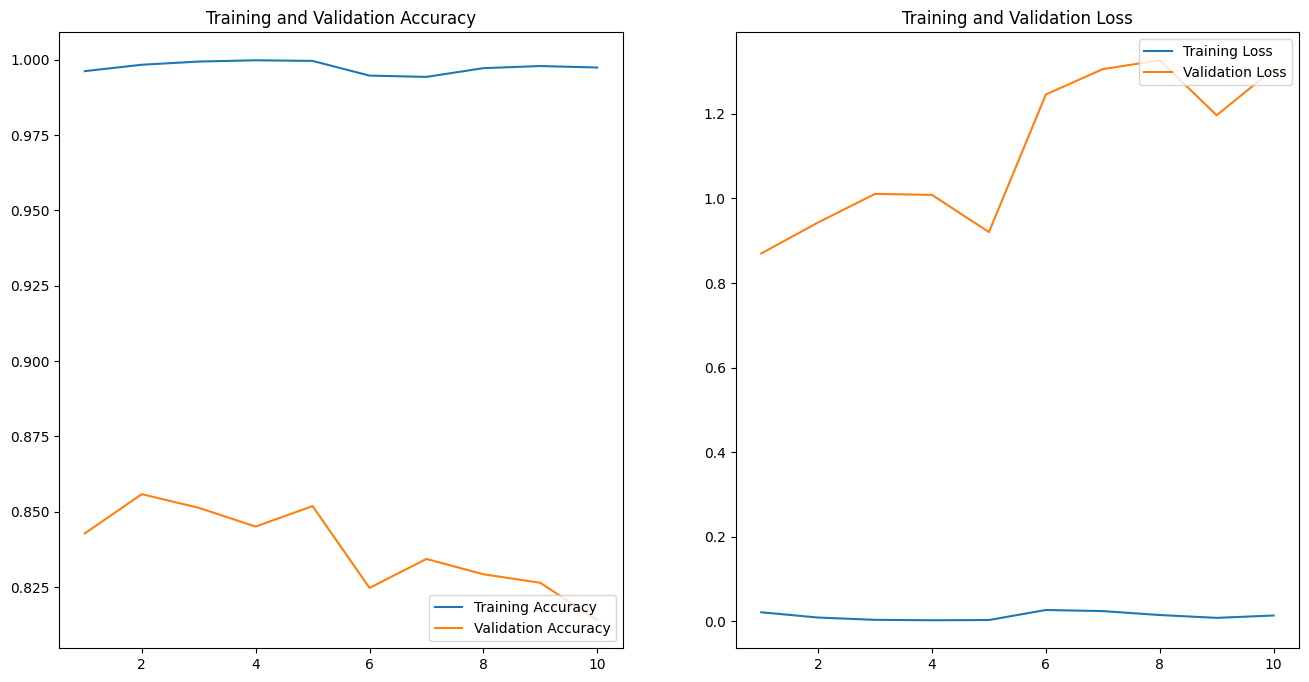

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

테스트 데이터에 대한 정확도는 80퍼를 넘겼다! 다만 더 상승하지는 않는다, 정규화도 적용해 보자

In [14]:
from tensorflow.keras.regularizers import l1_l2

model = tf.keras.Sequential([
    #Conv2D layer 설정 - 필터 32개, 커널 사이즈 3*3, 패딩 설정, 활성화 함수 relu, 첫 layer - 입력 이미지 크기 정의
    tf.keras.layers.Conv2D(
        16,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001), #l2 정규화 추가
        kernel_constraint=tf.keras.constraints.max_norm(3), #가중치 제한 
        input_shape=(img_height, img_width, 3),
    ),
    tf.keras.layers.Flatten(), #1차원 데이터로 변경
    tf.keras.layers.Dropout(0.5), #무작위 절반의 뉴런을 버림
    tf.keras.layers.Dense(classes, activation='softmax') #class의 종류 수 만큼 분류
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [30]:
num_epochs = 7
history = model.fit(train_2, epochs=num_epochs, validation_data=test)

Epoch 1/7


In [100]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout

def my_model(input_shape,num_classes):
    inputs=Input(shape=input_shape)
    
    x=Conv2D(64,kernel_size=(7,7),strides=(7,7),padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    x=Conv2D(32,kernel_size=(3,3), strides=(2,2),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    x=Flatten()(x)
    x=Dropout(0.3)(x)
    x=Dense(num_classes,activation='softmax')(x)

    model=tf.keras.models.Model(inputs=inputs,outputs=x)
    return model

model=my_model([img_height, img_width, 3], classes)
optimizer=Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
    
    

In [101]:
history = model.fit(train_1, epochs=1000, validation_data=test)

Epoch 1/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.4296 - loss: 2.4566 - val_accuracy: 0.0267 - val_loss: 3.6547
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7673 - loss: 0.9306 - val_accuracy: 0.0787 - val_loss: 3.4674
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8230 - loss: 0.6991 - val_accuracy: 0.1385 - val_loss: 3.1382
Epoch 4/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8582 - loss: 0.5493 - val_accuracy: 0.6191 - val_loss: 1.6930
Epoch 5/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8886 - loss: 0.4352 - val_accuracy: 0.7231 - val_loss: 1.1253
Epoch 6/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9028 - loss: 0.3799 - val_accuracy: 0.8022 - val_loss: 0.8183
Epoch 7/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9162 - loss: 0.3227 - val_accuracy: 0.8086 - val_loss: 0.7382
Epoch 8/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9390 - loss: 0.2490 - val_acc

In [95]:
model.save("models/my_model.keras")

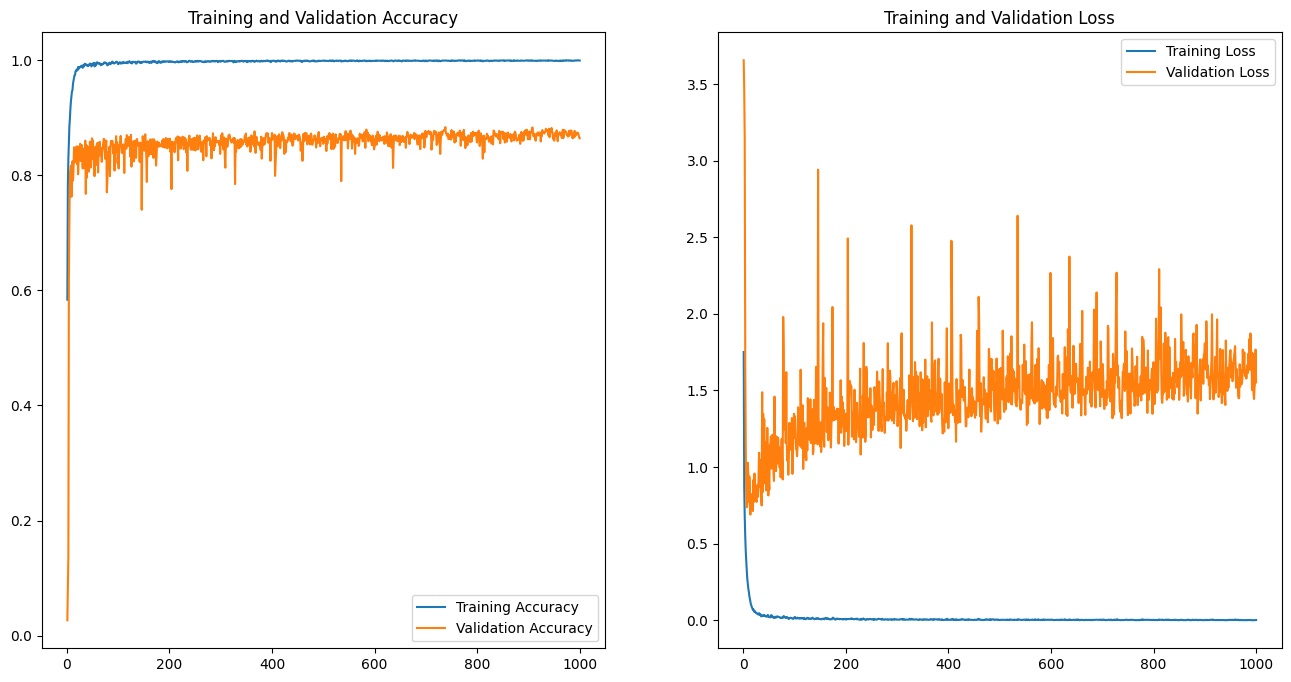

In [103]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 1000 + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()